  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -0.007359944598386369
        x: [ 3.811e-01  6.525e-01 ...  1.147e+00  1.697e+00]
      nit: 2
      jac: [ 5.218e-06  4.836e-06 ...  2.771e-06 -3.804e-06]
     nfev: 903
     njev: 3
 hess_inv: <300x300 LbfgsInvHessProduct with dtype=float64>
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.7471464053448129
       x: [ 8.019e-02  1.504e-01 ...  8.962e-01  2.077e+00]
     nit: 77
     jac: [ 1.723e-05  6.154e-06 ... -3.733e-06  3.926e-06]
    nfev: 23178
    njev: 77


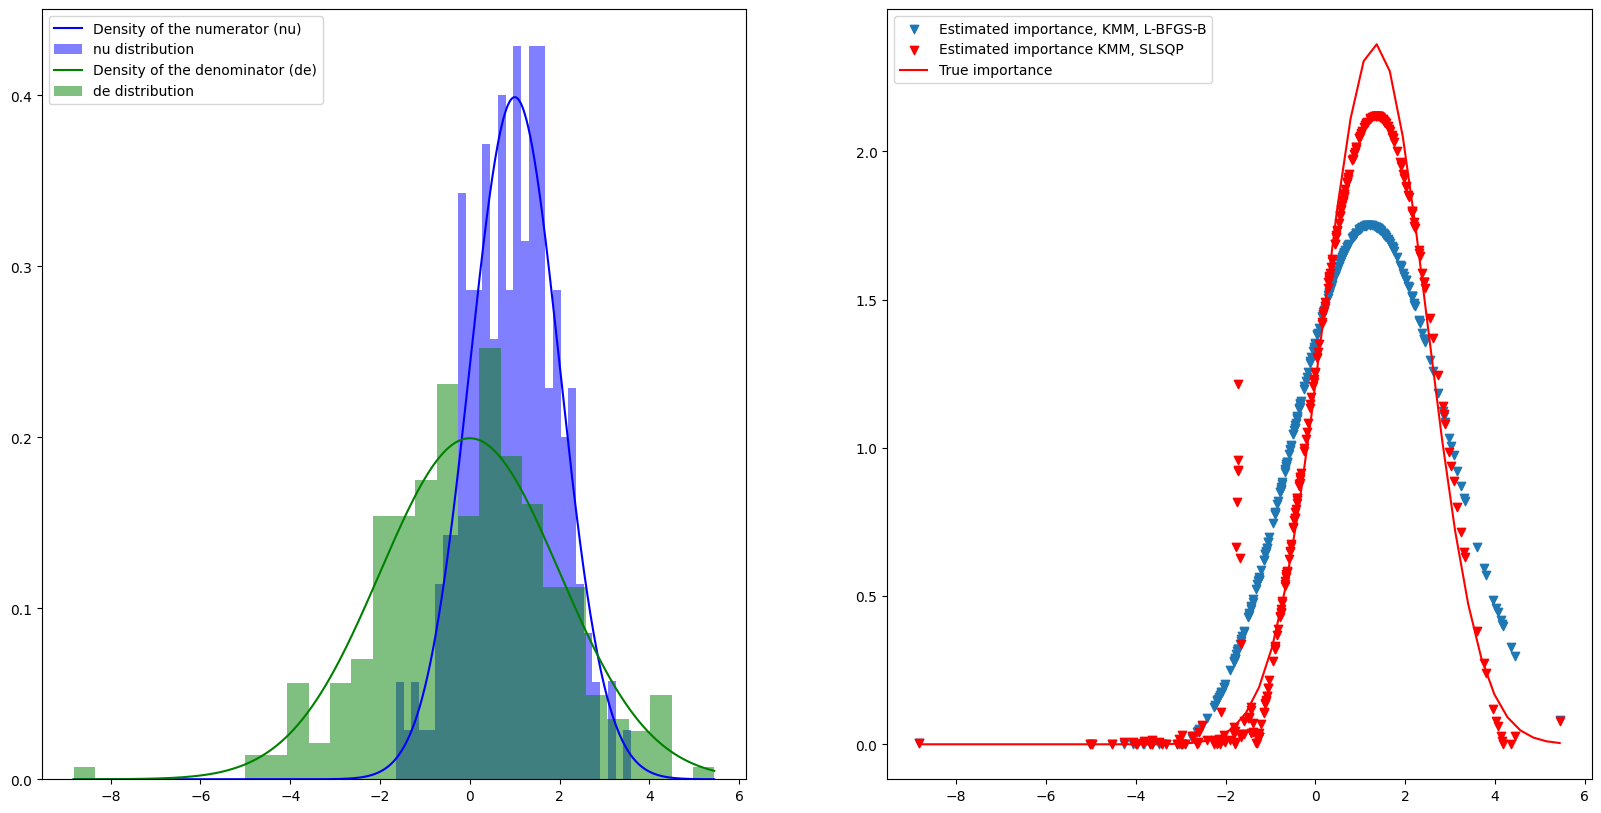

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import time
import importlib
from mpl_toolkits.mplot3d import Axes3D
import functions

importlib.reload(functions)


plot_precision = 1000

# inital parameters
n_nu, mu_nu, sigma_nu = 200, 1, 1
n_de, mu_de, sigma_de = 300, 0, 2

# create randomized data
nu_data = np.random.normal(loc = mu_nu, scale = sigma_nu, size = n_nu)
de_data = np.random.normal(loc = mu_de, scale = sigma_de, size = n_de)

# define densities functions for comparison
f_nu = lambda x: 1/np.sqrt(2*np.pi*sigma_nu**2)*np.exp(-(x - mu_nu)**2/(2*sigma_nu**2))
f_de = lambda x: 1/np.sqrt(2*np.pi*sigma_de**2)*np.exp(-(x - mu_de)**2/(2*sigma_de**2))

# ratio to be estimated
w = lambda x: f_nu(x)/f_de(x)

tmp_nu = list(nu_data)
tmp_de = list(de_data)

n_nu = len(nu_data)
n_de = len(de_data)
l = []


for i in range(n_nu):
    for j in range(n_de):
        l.append(np.linalg.norm(nu_data[i]- de_data[j]))

#combined = sorted(tmp_nu + tmp_de) 
l = sorted(l)
sigma = np.median(l)


K = lambda x,y: np.exp(-(x-y)**2/(2*sigma**2))
r1 = functions.KMM_inf_approach_w_nonneg(de_data, nu_data, "L-BFGS-B", K)
r2 = functions.KMM_inf_approach_w_nonneg(de_data, nu_data, "SLSQP", K)
x = np.linspace(min(min(de_data), min(nu_data)), max(max(de_data), max(nu_data)), plot_precision)
x2 = np.linspace(min(de_data), max(de_data))

_, ax = plt.subplots(1, 2, figsize = (20, 10))

ax[0].plot(x, f_nu(x), label = "Density of the numerator (nu)", color = "blue")
ax[0].hist(nu_data, density = True, color = "blue", label = "nu distribution", alpha = 0.5, bins = 30)
ax[0].plot(x, f_de(x), label = "Density of the denominator (de)", color = "green")
ax[0].hist(de_data, density = True, color = "green", label = "de distribution", bins = 30, alpha = 0.5)
#ax[0].plot(x, w(x), label = "Importance", color = "red")
ax[0].legend()
ax[1].scatter(de_data, r1, label = "Estimated importance, KMM, L-BFGS-B", marker = "v")
ax[1].scatter(de_data, r2, label = "Estimated importance KMM, SLSQP", marker = "v", color="red")
ax[1].plot(x2, w(x2), label = "True importance", color = "red")
ax[1].legend()



In [53]:
w = de_data
n_de = len(de_data)
K_de = np.array([[K(de_data[i], de_data[j]) for j in range(n_de)] for i in range(n_de)])+ 10e-2 * np.eye(n_de)
print(w.reshape(-1,1).shape)
print(K_de.shape)

np.transpose(w.reshape(-1,1)) @ K_de @ w-np.transpose(w.reshape(-1,1)) @ K_de @ np.ones((n_de, 1))

(300, 1)
(300, 300)


array([[68865.77008145]])